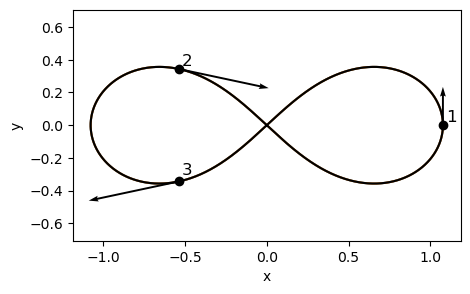

In [132]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the three-body ODE system in the plane for equal masses (m=1)
def three_body(t, y):
    # y contains [x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3]
    r1 = y[0:2]
    r2 = y[2:4]
    r3 = y[4:6]
    v1 = y[6:8]
    v2 = y[8:10]
    v3 = y[10:12]
    
    def acceleration(ri, rj, rk):
        return (rj - ri) / np.linalg.norm(rj - ri)**3 + (rk - ri) / np.linalg.norm(rk - ri)**3
    
    a1 = acceleration(r1, r2, r3)
    a2 = acceleration(r2, r1, r3)
    a3 = acceleration(r3, r1, r2)
    
    return np.concatenate((v1, v2, v3, a1, a2, a3))

# Initial conditions for the figure-eight choreography (extracted from Kapela & Simó paper)
x1, y1 = 1.07614373351, 0.0
vx1, vy1 = 0.0, 0.46826621840
#x1, y1 = 1.1, 0.0 (try different values: what happens?)
#vx1, vy1 = 0.0, 0.5
x2, y2 = -0.53807186675, -0.34370682775
vx2, vy2 = -1.09960375207, -0.23413310920
# Third body ensures center of mass at origin
x3, y3 = -(x1 + x2), -(y1 + y2)
vx3, vy3 = -(vx1 + vx2), -(vy1 + vy2)

y0 = np.array([x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3])

# Integrate over one period (approx 2*pi)
T = 2*np.pi
t_eval = np.linspace(0, T, 20000)
sol = solve_ivp(three_body, [0, T], y0, t_eval=t_eval, rtol=1e-12, atol=1e-12, method='Radau')

# Extract positions
x1_traj, y1_traj = sol.y[0], sol.y[1]
x2_traj, y2_traj = sol.y[2], sol.y[3]
x3_traj, y3_traj = sol.y[4], sol.y[5]


plt.figure(figsize=(5, 3))


plt.scatter([x1, x2, x3], [y1, y2, y3], color='black', zorder=15, label='Initial positions')

# Plot velocity vectors at initial positions
plt.quiver(
    [x1, x2, x3], [y1, y2, y3],  
    [vx1, vx2, vx3], [vy1, vy2, vy3], 
    angles='xy', scale_units='xy', scale=2, color='black', width=0.005, zorder=14
)


plt.plot(x1_traj, y1_traj, label='Body 1', zorder=10, color='black')
plt.plot(x2_traj, y2_traj, label='Body 2')
plt.plot(x3_traj, y3_traj, label='Body 3')


plt.text(x1 + 0.02, y1 + 0.02, '1', fontsize=12)
plt.text(x2 + 0.02, y2 + 0.04, '3', fontsize=12)
plt.text(x3 + 0.02, y3 + 0.02, '2', fontsize=12)

plt.axis('equal')
#plt.title('Figure Eight Choreography (3-Body Problem)')
plt.xlabel('x')
plt.ylabel('y')
#plt.legend()
plt.savefig('eight_orbit.pdf')
plt.show()




In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root
import matplotlib.pyplot as plt


def six_body_ode(t, y):
    r = y[:12].reshape(6,2)
    v = y[12:].reshape(6,2)
    a = np.zeros_like(r)
    for i in range(6):
        for j in range(6):
            if i != j:
                diff = r[j] - r[i]
                a[i] += diff / np.linalg.norm(diff)**3
    return np.hstack((v.flatten(), a.flatten()))


def φ(x0, τ, rtol=1e-9, atol=1e-9):
    sol = solve_ivp(six_body_ode, [0, τ], x0,
                    rtol=rtol, atol=atol, method='DOP853')
    return sol.y[:, -1]

def σ(x):
    S = x.reshape(6,4)
    S = np.roll(S, -1, axis=0)    # shift all bodies forward by one
    return S.flatten()


T = 2*np.pi  
N = 6         # number of bodies
k = 3         # number of shooting intervals
τ = T/(N*k)   # time per sub-interval


z0 = np.array([
    1.65664706, -0.64689132,
    0.59294259,  0.17186502,
    -2.17431535,  0.50023185,
    -0.50169146,  0.53779281,
    0.41392017,  0.16258946,
    -1.14921834, -0.11931360,
    -1.71442918, -0.31427360,
    -1.08742527, -0.53240619,
    1.27714030,  0.74254988
])


x1, vy1 = z0[0], z0[1]
q2, p2 = z0[2:4], z0[4:6]
q3, p3 = z0[6:8], z0[8:10]
q4, p4 = z0[10:12], z0[12:14]
q5, p5 = z0[14:16], z0[16:18]


y1, vx1 = 0.0, 0.0


x6 = -(x1 + q2[0] + q3[0] + q4[0] + q5[0])
y6 = -(y1 + q2[1] + q3[1] + q4[1] + q5[1])
vx6 = -(vx1 + p2[0] + p3[0] + p4[0] + p5[0])
vy6 = -(vy1 + p2[1] + p3[1] + p4[1] + p5[1])


pos = np.vstack([
    [ x1,  y1],
    q2, q3, q4, q5,
    [ x6,  y6]
])
vel = np.vstack([
    [vx1, vy1],
    p2, p3, p4, p5,
    [vx6, vy6]
])
x0 = np.hstack((pos.flatten(), vel.flatten()))
assert x0.size == 24

x1_guess = φ(x0, τ)
x2_guess = φ(x1_guess, τ)
X0 = np.hstack((x0, x1_guess, x2_guess))

# The parallel-shooting residual F(X)=0:
def F(X):
    x0, x1, x2 = np.split(X, 3)
    r0 = σ(φ(x2, τ)) - x0
    r1 = φ(x0, τ) - x1
    r2 = φ(x1, τ) - x2
    return np.hstack((r0, r1, r2))

# Solve for X by Newton 
sol = root(F, X0, method='hybr', tol=1e-8)
if not sol.success:
    raise RuntimeError("Parallel shooting failed: " + sol.message)


x0_corr = sol.x[:12]

# Integrate x0_corr over one full T to get the trajectories
t_grid = np.linspace(0, T, 2000)
traj = solve_ivp(six_body_ode, [0, T], x0_corr, t_eval=t_grid,
                 rtol=1e-9, atol=1e-9, method='DOP853')


plt.figure(figsize=(7,7))
for i in range(6):
    xi = traj.y[2*i    , :]
    yi = traj.y[2*i + 1, :]
    plt.plot(xi, yi, label=f'Body {i+1}')
plt.axis('equal')
plt.title('6-Body Nonsymmetric Choreography\n(via Parallel Shooting)')
plt.xlabel('x'); plt.ylabel('y')
plt.legend()
plt.show()


RuntimeError: Parallel shooting failed: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.

In [113]:
print(0.1+0.1+0.1)

0.30000000000000004


/var/folders/_s/6dth5vq92x592870nqdgg1v40000gn/T/ipykernel_61353/1633770920.py:74: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  body1.set_data(r1[0, frame], r1[1, frame])
/var/folders/_s/6dth5vq92x592870nqdgg1v40000gn/T/ipykernel_61353/1633770920.py:75: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  body2.set_data(r2[0, frame], r2[1, frame])
/var/folders/_s/6dth5vq92x592870nqdgg1v40000gn/T/ipykernel_61353/1633770920.py:76: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  body3.set_data(r3[0, frame], r3[1, frame])


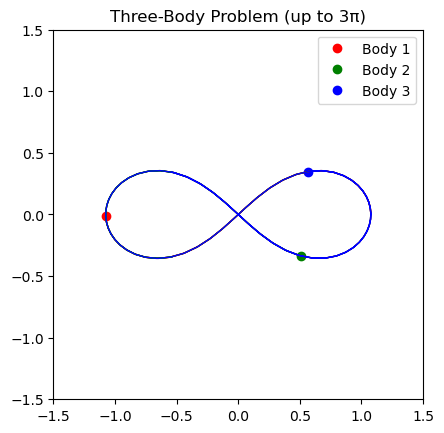

In [145]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter


def three_body(t, y):
    r1 = y[0:2]
    r2 = y[2:4]
    r3 = y[4:6]
    v1 = y[6:8]
    v2 = y[8:10]
    v3 = y[10:12]

    def acceleration(ri, rj, rk):
        return (rj - ri) / np.linalg.norm(rj - ri)**3 + (rk - ri) / np.linalg.norm(rk - ri)**3

    a1 = acceleration(r1, r2, r3)
    a2 = acceleration(r2, r1, r3)
    a3 = acceleration(r3, r1, r2)

    return np.concatenate((v1, v2, v3, a1, a2, a3))


x1, y1 = 1.07614373351, 0.0
vx1, vy1 = 0.0, 0.46826621840
x2, y2 = -0.53807186675, -0.34370682775
vx2, vy2 = -1.09960375207, -0.23413310920
x3, y3 = -(x1 + x2), -(y1 + y2)
vx3, vy3 = -(vx1 + vx2), -(vy1 + vy2)

y0 = np.array([x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3])

# Time span
T = 3*np.pi
t_points = np.arange(0, T, 0.1)
sol = solve_ivp(three_body, [0, T], y0, t_eval=t_points, rtol=1e-12, atol=1e-12, method='Radau')


r1 = sol.y[0:2, :]
r2 = sol.y[2:4, :]
r3 = sol.y[4:6, :]


fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_title("Three-Body Problem (up to 3π)")


body1, = ax.plot([], [], 'ro', label='Body 1')
body2, = ax.plot([], [], 'go', label='Body 2')
body3, = ax.plot([], [], 'bo', label='Body 3')

trail1, = ax.plot([], [], 'r-', lw=1)
trail2, = ax.plot([], [], 'g-', lw=1)
trail3, = ax.plot([], [], 'b-', lw=1)

ax.legend()

def init():
    body1.set_data([], [])
    body2.set_data([], [])
    body3.set_data([], [])
    trail1.set_data([], [])
    trail2.set_data([], [])
    trail3.set_data([], [])
    return body1, body2, body3, trail1, trail2, trail3

def update(frame):
    # Update body positions
    body1.set_data(r1[0, frame], r1[1, frame])
    body2.set_data(r2[0, frame], r2[1, frame])
    body3.set_data(r3[0, frame], r3[1, frame])
    
    # Update trails
    trail1.set_data(r1[0, :frame+1], r1[1, :frame+1])
    trail2.set_data(r2[0, :frame+1], r2[1, :frame+1])
    trail3.set_data(r3[0, :frame+1], r3[1, :frame+1])
    
    return body1, body2, body3, trail1, trail2, trail3

ani = FuncAnimation(fig, update, frames=len(t_points), init_func=init, blit=True)


writer = FFMpegWriter(fps=10,bitrate=10000)
ani.save("three_body_with_trails.mp4", writer=writer)

plt.show()
